In [2]:
import numpy as np       # import numpy zum Matrizen und Vektor rechnen
import tensorflow as tf  # keras zu tensorflow importieren
import cv2               # import opencv
import matplotlib.pyplot as plt # plt ermöglicht Graphen und Bilder auszugeben

from tensorflow.keras.models import Sequential # import Sequentielles Keras Modell
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten # import von verschiedenen Layerarten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD # Optimierer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model  # von keras datasets, layers und modelle importieren
from IPython.display import Image # um Bilder darzustellen
from tensorflow.keras.applications import imagenet_utils # 
from sklearn.metrics import confusion_matrix
import itertools

print("import done")

physical_devices = tf.config.experimental.list_physical_devices('GPU') # zum auslesen ob eine GPU verbaut ist
print("Num GPUs Available: ", len(physical_devices)) # Anzahl GPUs ausgeben
tf.config.experimental.set_memory_growth(physical_devices[0], True) # Tensorflow auf diese GPU einstellen

import done
Num GPUs Available:  1


In [18]:
model = Sequential()  # Sequentielles Modell, when 1 Input und 1 Output

# ersten 2 Conv Layer. Erster Conv Layer bekommt die Bildgröße
model.add(Conv2D(input_shape = (224, 224, 3), filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))  # pooling mit filtergröße 2x2 und strides (x+2,y+2)

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2))) 

model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"))

model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))

# Dense und Softmax Layer
model.add(Flatten())
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dense(units = 2, activation = "softmax")) #sigmoid

opt = SGD(lr = 0.001) #z.B. SGD oder ADAM # optimierer Learning Rate = 0.001 , zwischen 0.01 - 0.0001 -> kleinere Schritte um zum minimalen Loss zu kommen
model.compile(optimizer = opt, loss= tf.keras.losses.categorical_crossentropy, metrics = ['accuracy']) # Accuracy berechnet wie of Vorhersage = Label #categorical_crossentropy
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [5]:
!unzip /content/10kBilderv4.zip

trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/content/10kBilderv4/train",target_size=(224,224),classes=['gesund', 'krank'],class_mode='categorical') # class_mode default: categorical
valdata = ImageDataGenerator()
validationdata = valdata.flow_from_directory(directory="/content/10kBilderv4/validation", target_size=(224,224),classes=['gesund', 'krank'],class_mode='categorical')
tst1data = ImageDataGenerator()
testt1data = tst1data.flow_from_directory(directory="/content/10kBilderv4/testT1",target_size=(224,224),classes=['gesund', 'krank'],class_mode='categorical',shuffle=False)
tst2data = ImageDataGenerator()
testt2data = tst2data.flow_from_directory(directory="/content/10kBilderv4/testT2",target_size=(224,224),classes=['gesund', 'krank'],class_mode='categorical',shuffle=False)

ptr=traindata.class_indices
print(ptr)
pva=validationdata.class_indices
print(pva)
ptet1=testt1data.class_indices
print(ptet1)
ptet2=testt2data.class_indices
print(ptet2)

Archive:  /content/10kBilderv4.zip
replace 10kBilderv4/testT1/gesund/T1T2_16012021_GesundMiriYannik.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
{'gesund': 0, 'krank': 1}
{'gesund': 0, 'krank': 1}
{'gesund': 0, 'krank': 1}
{'gesund': 0, 'krank': 1}


In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("weight10kBilderv4.h5",
                                                monitor="val_accuracy",
                                                verbose = 1,
                                                save_best_only = True,
                                                save_weights_only = False,
                                                mode= "auto",
                                                save_freq= "epoch",
                                                options=None)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=50,
                      verbose=1,
                      mode='auto')

hist = model.fit(x=traindata,
                          steps_per_epoch = 625,
                          epochs = 15,
                          batch_size = 32,
                          validation_data = validationdata,
                          validation_steps = 15,
                          callbacks = [checkpoint,early])

model.save('model10kBilderv4.h5')

Epoch 1/15
625/625 [==============================] - 535s 833ms/step - loss: 0.6953 - accuracy: 0.4965 - val_loss: 0.6949 - val_accuracy: 0.4979

Epoch 00001: val_accuracy improved from -inf to 0.49792, saving model to weight10kBilderv4.h5
Epoch 2/15
625/625 [==============================] - 522s 836ms/step - loss: 0.6925 - accuracy: 0.5144 - val_loss: 0.6925 - val_accuracy: 0.5146

Epoch 00002: val_accuracy improved from 0.49792 to 0.51458, saving model to weight10kBilderv4.h5
Epoch 3/15
625/625 [==============================] - 522s 835ms/step - loss: 0.6900 - accuracy: 0.5321 - val_loss: 0.6910 - val_accuracy: 0.5229

Epoch 00003: val_accuracy improved from 0.51458 to 0.52292, saving model to weight10kBilderv4.h5
Epoch 4/15
625/625 [==============================] - 522s 835ms/step - loss: 0.6877 - accuracy: 0.5445 - val_loss: 0.6851 - val_accuracy: 0.5583

Epoch 00004: val_accuracy improved from 0.52292 to 0.55833, saving model to weight10kBilderv4.h5
Epoch 5/15
625/625 [=======

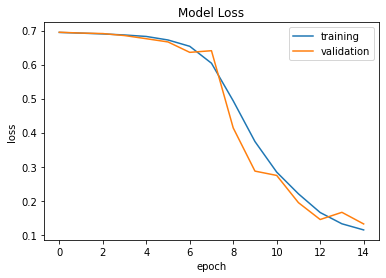

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

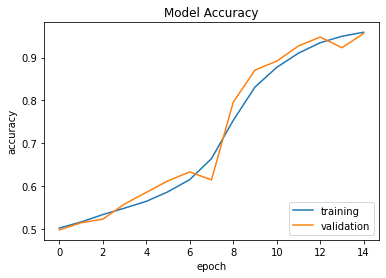

In [23]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [ ]:
img = image.load_img("/content/10kBilderv4/testT1/gesund/T1_10.jpg",target_size=(224,224))

img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
saved_model = load_model("weight10kBilderv4.h5")
output = saved_model.predict(img)
print(output)
if output[0][0] > output[0][1]:
    print("gesund")
else:
    print('krank')

In [ ]:
picturefile="10kBilderv4"
testcount = 100
savefile = open("/content/werte.csv",'w+')


testpicture = "T1"

savefile.write("Ergebnisse von " + testpicture + " gesund: \n")

for i in range(1, testcount+1):
    print (i)
    img = image.load_img("/content/" + picturefile + "/test" + testpicture + "/gesund/" + testpicture + "_" + str(i) + ".jpg",target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    saved_model = load_model("/content/weight" + picturefile + ".h5")
    output = saved_model.predict(img)
    print(output)
    if output[0][0] > output[0][1]:
        print("gesund")
        ergebnis="gesund"
        match = 1
    else:
        print('krank')
        ergebnis="krank"
        match = 0
    savefile.write(str(i) + "; original : ;" + testpicture + " gesund ; test ergibt: ;" + ergebnis + " ; richtig: ; " + str(match) + " ; Wahrscheinlichkeit: ;" + str(saved_model.predict(img)) + "\n")

savefile.write("Ergebnisse von " + testpicture + " krank: \n")

for i in range(1, testcount+1):
    print (i)
    img = image.load_img("/content/" + picturefile + "/test" + testpicture + "/krank/" + testpicture + "_" + str(i) + ".jpg",target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    saved_model = load_model("/content/weight" + picturefile + ".h5")
    output = saved_model.predict(img)
    print(output)
    if output[0][0] > output[0][1]:
        print("gesund")
        ergebnis="gesund"
        match = 0
    else:
        print('krank')
        ergebnis="krank"
        match = 1
    savefile.write(str(i) + "; original : ;" + testpicture + " krank ; test ergibt: ;" + ergebnis + " ; richtig: ; " + str(match) + " ; Wahrscheinlichkeit: ;" + str(saved_model.predict(img)) + "\n")


testpicture = "T2"

savefile.write("Ergebnisse von " + testpicture + " gesund: \n")

for i in range(1, testcount+1):
    print (i)
    img = image.load_img("/content/" + picturefile + "/test" + testpicture + "/gesund/" + testpicture + "_" + str(i) + ".jpg",target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    saved_model = load_model("/content/weight" + picturefile + ".h5")
    output = saved_model.predict(img)
    print(output)
    if output[0][0] > output[0][1]:
        print("gesund")
        ergebnis="gesund"
        match = 1
    else:
        print('krank')
        ergebnis="krank"
        match = 0
    savefile.write(str(i) + "; original : ;" + testpicture + " gesund ; test ergibt: ;" + ergebnis + " ; richtig: ; " + str(match) + " ; Wahrscheinlichkeit: ;" + str(saved_model.predict(img)) + "\n")

savefile.write("Ergebnisse von " + testpicture + " krank: \n")

for i in range(1, testcount+1):
    print (i)
    img = image.load_img("/content/" + picturefile + "/test" + testpicture + "/krank/" + testpicture + "_" + str(i) + ".jpg",target_size=(224,224))
    img = np.asarray(img)
    #plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    saved_model = load_model("/content/weight" + picturefile + ".h5")
    output = saved_model.predict(img)
    print(output)
    if output[0][0] > output[0][1]:
        print("gesund")
        ergebnis="gesund"
        match = 0
    else:
        print('krank')
        ergebnis="krank"
        match = 1
    savefile.write(str(i) + "; original : ;" + testpicture + " krank ; test ergibt: ;" + ergebnis + " ; richtig: ; " + str(match) + " ; Wahrscheinlichkeit: ;" + str(saved_model.predict(img)) + "\n")

savefile.close()

Confusion matrix, without normalization
[[98  2]
 [ 8 92]]


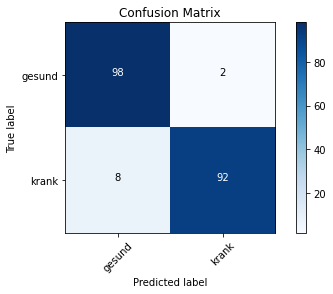

In [6]:
model = load_model("/content/weight10kBilderv4.h5")

batch_size = 10
num_of_test_samples = 200

predictions = model.predict(testt1data,  num_of_test_samples // batch_size+1)

rounded_predictions = np.argmax(predictions, axis=-1)

true_classes = testt1data.classes

class_labels = list(testt1data.class_indices.keys())   

cm = confusion_matrix(testt1data.classes, y_pred=rounded_predictions)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black") #TODO

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['gesund','krank']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[56 44]
 [13 87]]


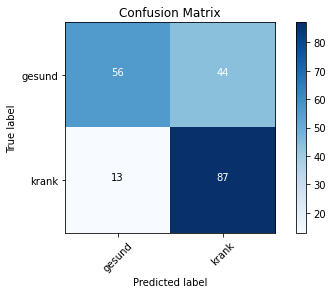

In [14]:
model = load_model("/content/weight10kBilderv4.h5")

batch_size = 10
num_of_test_samples = 200

predictions = model.predict(testt2data,  num_of_test_samples // batch_size+1)

rounded_predictions = np.argmax(predictions, axis=-1)

true_classes = testt2data.classes

class_labels = list(testt2data.class_indices.keys())   

cm = confusion_matrix(testt2data.classes, y_pred=rounded_predictions)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black") #TODO

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = ['gesund','krank']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')